## Loading libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV   
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

## Loading the data

In [2]:
df_Tree = pd.read_csv('Cleaned Data Tree.csv')

## Set index as customer ID

In [3]:
df_Tree_ID = df_Tree.set_index('Customer_ID')

## Extract X and Y from data

In [4]:
X = df_Tree_ID.drop(['churn'],axis=1)

In [5]:
y = pd.DataFrame(df_Tree_ID['churn'])

## Lets see how the algorithm trains

In [6]:
def plot_errors(clf,X,y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

    eval_set = [(X_train, y_train), (X_test, y_test)]

    clf.fit(X_train, y_train, eval_metric=["error", "auc"], eval_set=eval_set, verbose=False)

    plt.rcParams["figure.figsize"] = (8,8)

    # make predictions for test data
    y_pred = clf.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

    # retrieve performance metrics
    results = clf.evals_result()
    epochs = len(results['validation_0']['error'])
    x_axis = range(0, epochs)

    # plot log loss
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['auc'], label='Train')
    ax.plot(x_axis, results['validation_1']['auc'], label='Test')
    ax.legend()
    plt.ylabel('AUC')
    plt.title('XGBoost AUC')
    plt.show()
    # plot classification error
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['error'], label='Train')
    ax.plot(x_axis, results['validation_1']['error'], label='Test')
    ax.legend()
    plt.ylabel('Classification Error')
    plt.title('XGBoost Classification Error')
    plt.show()

Accuracy: 62.99%


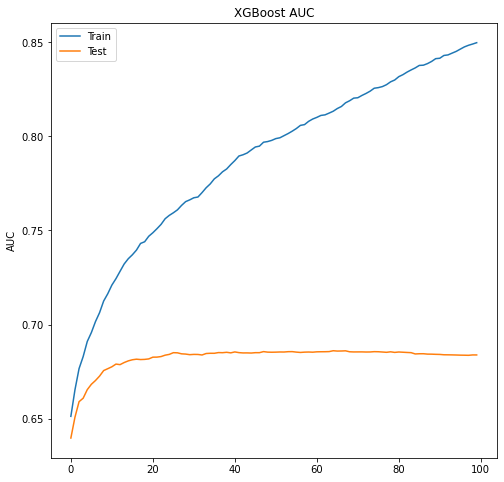

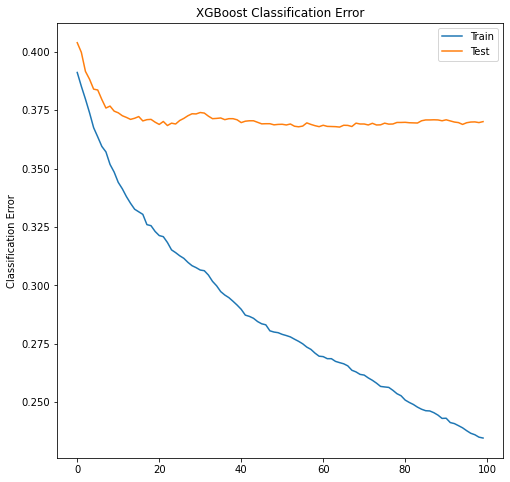

In [7]:
clf_xgb = xgb.XGBClassifier()

plot_errors(clf_xgb,X,y)

From the above graphs we infer that model learns really well until 20th iteration but then Test scores become constant. Model starts to overfit

### Lets plot the feature importance

<Figure size 2880x1440 with 0 Axes>

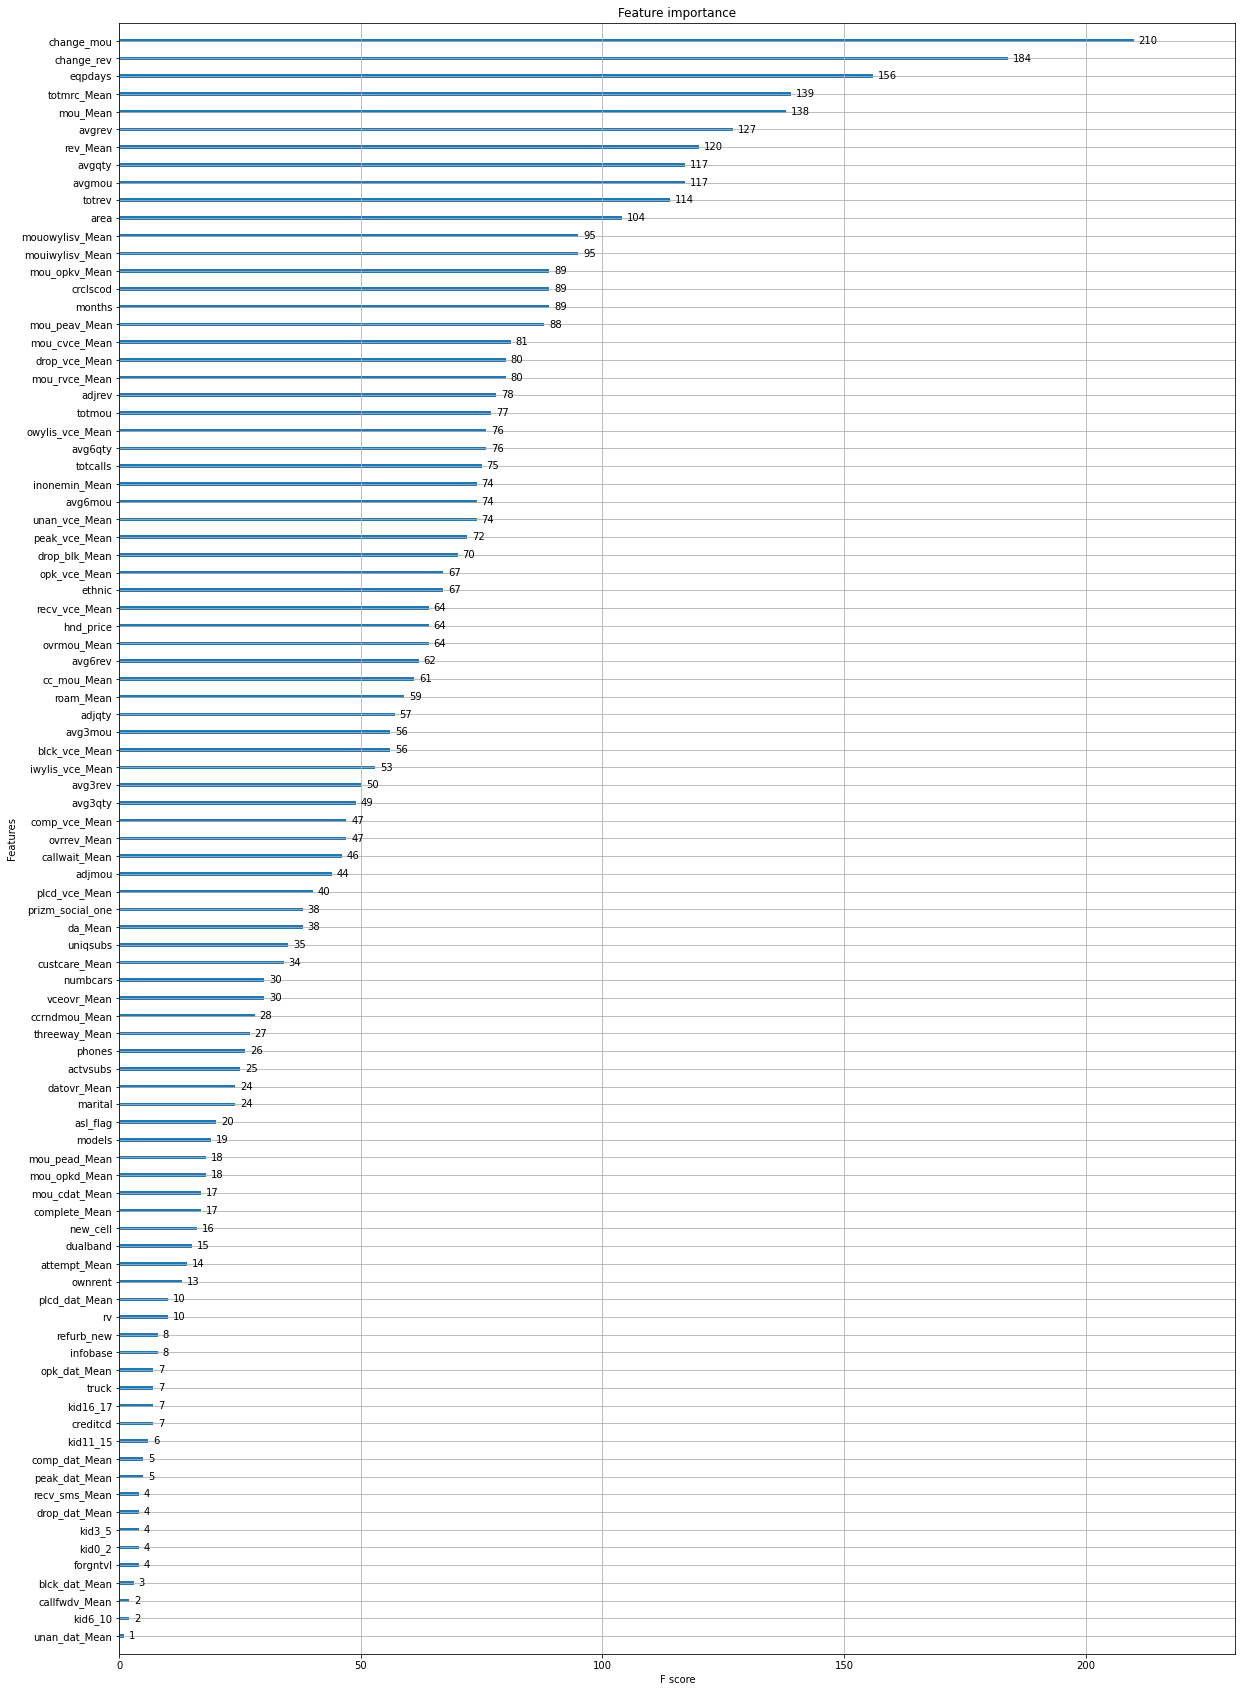

In [13]:
# plot feature importance
from xgboost import plot_importance
plt.figure(figsize=(40,20))
ax_sub = plot_importance(clf_xgb,max_num_features=100)
#plt.savefig('Feature Importances',dpi=1200)
plt.rcParams["figure.figsize"] = (20,30)
plt.show()

# get the original names back
Text_yticklabels = list(ax_sub.get_yticklabels())

In [14]:
dict1 = [ Text_yticklabels[i].get_text() for i in range(len(Text_yticklabels))]

In [15]:
#Choose the top 40 features

X_feat = X[dict1[40:100]]

Accuracy: 62.41%


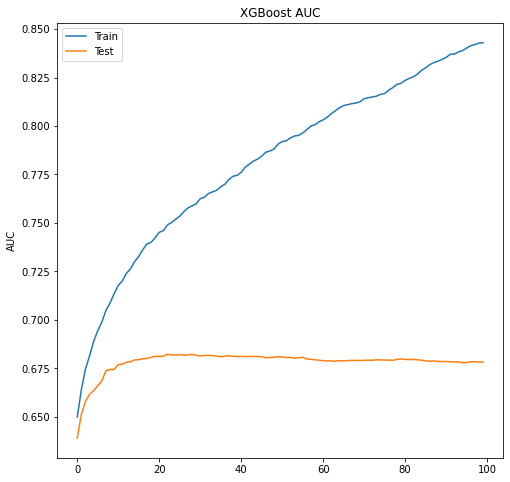

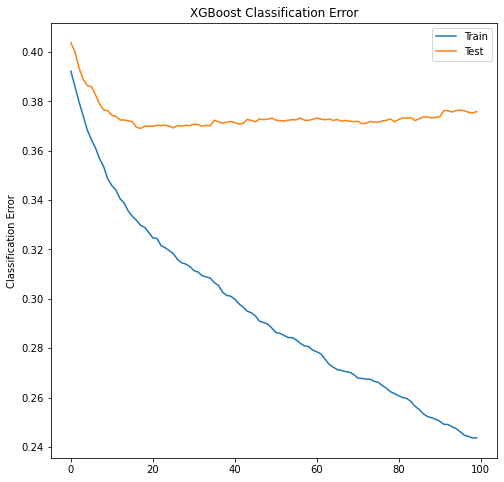

In [16]:
clf_xgb_feat = xgb.XGBClassifier()

plot_errors(clf_xgb_feat,X_feat,y)

## Step 1: Fix learning rate and number of estimators for tuning tree-based parameters

In [27]:
X_train_fix, X_test_fix, y_train_fix, y_test_fix = train_test_split(X_feat, y, test_size=0.2,random_state=42)

clf_xgb_fix = xgb.XGBClassifier(
                     learning_rate =0.1,
                     n_estimators=100,
                     max_depth=5,
                     min_child_weight=1,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     objective= 'binary:logistic',
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27)
clf_xgb_fix.fit(X_train_fix, y_train_fix)

y_pred = clf_xgb_fix.predict(X_test_fix)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test_fix, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 63.35%


## Tune max_depth and min_child_weight

In [28]:
param_test1 = { 'learning_rate = [0.05, 0.1, 0.2, 0.3],
                'max_depth':range(3,10,2),
                'min_child_weight':range(1,6,2) }

gsearch1 = GridSearchCV(clf_xgb_fix, param_grid = param_test1, scoring='accuracy',n_jobs=-1,iid=False, cv=5)

gsearch1.fit(X_train_fix, y_train_fix)

gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'